Siamese Neural Network

A Siamese neural network features two identical branches, each designed to process one of the two signatures being compared. These branches share the same weights and architecture, ensuring uniform processing of both signatures. The network outputs, usually feature vectors, are then compared to assess the similarity between the signatures.

Contrastive Loss Function

The contrastive loss function calculates the difference between the outputs of the two branches. It penalizes the network if the difference is too small for non-matching (forged) signatures or too large for matching (genuine) signatures. This way, the network learns to differentiate between genuine and forged signatures effectively.

Preprocessing for Improved Performance

To enhance the network's performance, it's crucial to preprocess the signatures before training. Effective preprocessing steps include:

Removing the Background: Eliminating any non-signature elements.

Centering the Signature: Ensuring the signature is centered on the canvas.

Resizing: Adjusting the signature to a fixed size (e.g., 170x242 pixels).

These preprocessing steps standardize the input data, making it easier for the network to learn the distinguishing features of signatures, thereby improving verification accuracy.




Load data

In [2]:
import pandas as pd
# Train data

train = pd.read_csv('C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/train_data.csv')
train.rename(columns={"1":"label"}, inplace=True)
train["image_real_paths"] = train["068/09_068.png"].apply(lambda x: f"C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/train/{x}")
train["image_forged_paths"] = train["068_forg/03_0113068.PNG"].apply(lambda x: f"C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/train/{x}")

# Test data
test = pd.read_csv('C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/test/{x}")

In [3]:
test

,068/09_068.png,068_forg/03_0113068.PNG,label,image_real_paths,image_forged_paths
0,068/09_068.png,068_forg/01_0124068.PNG,1,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
1,068/09_068.png,068_forg/02_0124068.PNG,1,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
2,068/09_068.png,068_forg/01_0113068.PNG,1,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
3,068/09_068.png,068_forg/04_0124068.PNG,1,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
4,068/09_068.png,068_forg/04_0113068.PNG,1,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
...,...,...,...,...,...
5742,066/01_066.png,066/06_066.png,0,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
5743,066/01_066.png,066/08_066.png,0,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
5744,066/01_066.png,066/02_066.png,0,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...
5745,066/01_066.png,066/05_066.png,0,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...,C:/Users/Mahdi/Desktop/PFE FST/data/sign_data/...


In [4]:
train["label"].value_counts(normalize=True)

label
0    0.543073
1    0.456927
Name: proportion, dtype: float64

In [5]:
test["label"].value_counts(normalize=True)

label
1    0.517661
0    0.482339
Name: proportion, dtype: float64

Directory

In [9]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Configuration

In [6]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=20
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=32
    lr=1e-3
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["label"].shape[0]
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    projection2d=True
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

Libraries

In [10]:
import pandas as pd

import numpy as np
import wandb
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

W&B

In [ ]:
# use your wandb api to login and replace wandb_api with your own key
wandb_api = '8ea864ca2380035688a7de9c846bc05808d470cb'
import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Signature",
                 name="convnet2",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

utils

In [11]:
def get_score(y_true, y_pred):
    score = accuracy_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

Data Pre-processing

In [12]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [13]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = train.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

Shows pre-processed samples of the two users

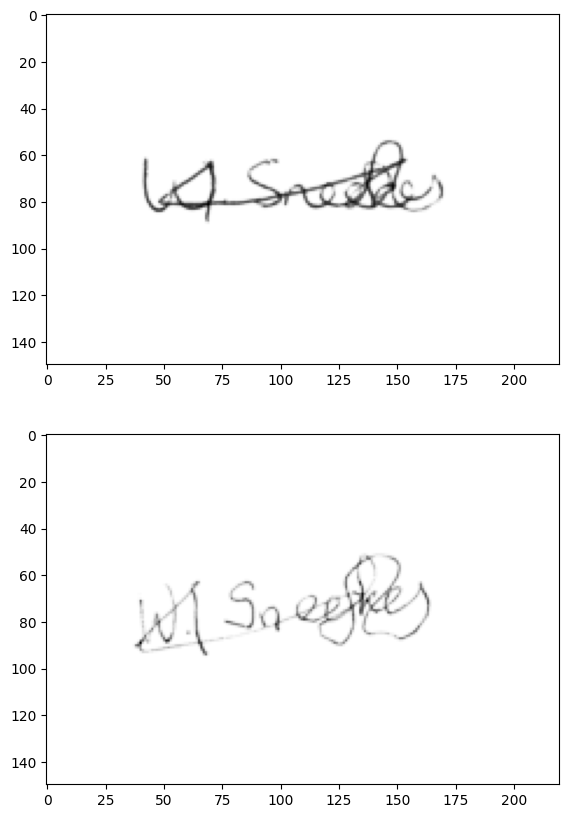

In [14]:
f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

Dataaset

In [15]:
class SignatureDataset(Dataset):

    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]

        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)

        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)

        label = torch.tensor(self.labels[index], dtype=torch.long)

        return torch.tensor(img1), torch.tensor(img2), label.float()

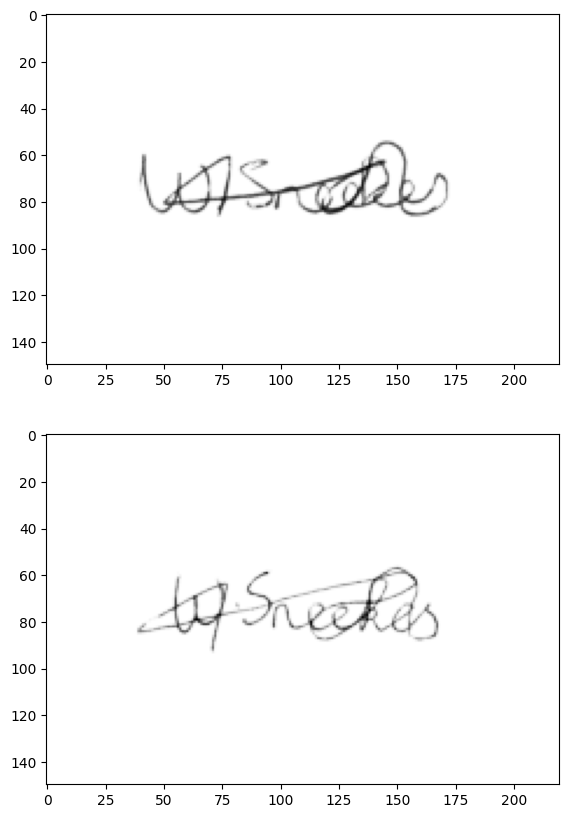

In [16]:
train_dataset = SignatureDataset(train, canvas_size, input_size)
img1, img2, _ = train_dataset[1]

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(img1)
ax[1].imshow(img2)

Contrastive loss


In Contrastive loss, pairs of images are taken. For same class pairs, distance is less between them. For different pairs, distance is more. Although binary cross-entropy seems like a perfect loss function for our problem, the contrastive loss does a better job differentiating between image pairs. Contrastive loss, L = Y * D^2 + (1-Y) * max(margin — D, 0)^2

D is the distance between image features. ‘margin’ is a parameter that helps us pushing different classes apart.

In [17]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.cosine_similarity(F.normalize(output1), F.normalize(output2))
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

Models

using pretrained model SigNet and creating a new Siamese model to compare the two signatures 

In [18]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))

    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x

    def forward(self, img1, img2):

        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('mish', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('mish', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("models/signet.pth")
        self.model.load_state_dict(state_dict)

        if CFG.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)

    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x

    def forward(self, img1, img2):

        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)

        if CFG.projection2d:
            #print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            print(output.shape)
            output= self.probs(output)
            return embedding1, embedding2, output

Helper functions

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterions, optimizer, epoch, scheduler, device):

    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (img1, img2, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        img1 = img1.to(device).float()
        img2 = img2.to(device).float()
        labels = labels.to(device)
        batch_size = labels.size(0)
        out1, out2, preds = model(img1, img2)
        loss1 = criterions[0](out1, out2, labels)
        loss2 = criterions[1](preds.squeeze(1), labels)
        loss = (loss1 + loss2) / 2

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps

        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print(f'Epoch: [{epoch}][{step}/{len(train_loader)}] ', end='')
            print(f'Elapsed: {timeSince(start, float(step+1)/len(train_loader))} ', end='')
            print(f'Loss: {losses.val:.4f}({losses.avg:.4f}) ', end='')
            print(f'Grad: {grad_norm:.4f} ', end='')
            if scheduler:
                print(f'LR: {scheduler.get_last_lr()[0]:.6f}  ')
            else:
                print(f'LR: {CFG.lr}')

        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_last_lr()[0]})
    return losses.avg

Train

In [ ]:
# ====================================================
# loader
# ====================================================
seed_torch(seed=CFG.seed)
train_dataset = SignatureDataset(train, CFG.canvas_size, dim=(256, 256))

train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,drop_last=True,pin_memory=True,shuffle=True)#shuffle=True


# ====================================================
# scheduler
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
    elif CFG.scheduler=='OneCycleLR':
        scheduler = OneCycleLR(optimizer, **CFG.onecycle_params)
    return scheduler

# ====================================================
# model & optimizer
# ====================================================
model = SiameseModel()
model.to(device)


optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
try:
    scheduler = get_scheduler(optimizer)
except:
    print('Learning scheduler is not used')



# ====================================================
# loop
# ====================================================
contrastive = ContrastiveLoss() # Contrastive loss
binary_cross = nn.BCEWithLogitsLoss() # Binary cross entropy
best_score = 0.
best_loss = np.inf

for epoch in range(CFG.epochs):
   

    start_time = time.time()

    # train
    avg_loss = train_fn(train, train_loader, model, [contrastive, binary_cross], optimizer, epoch, scheduler, device)


    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, OneCycleLR):
        scheduler.step()


    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  time: {elapsed:.0f}s')
    wandb.log({f"epoch": epoch+1,
                   f"avg_train_loss": avg_loss})


    if avg_loss < best_loss:
        best_loss = avg_loss
        LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        torch.save({'model': model.state_dict()},
                        OUTPUT_DIR+f'{CFG.model_name}_best_loss.pt')

wandb.finish()

training loss

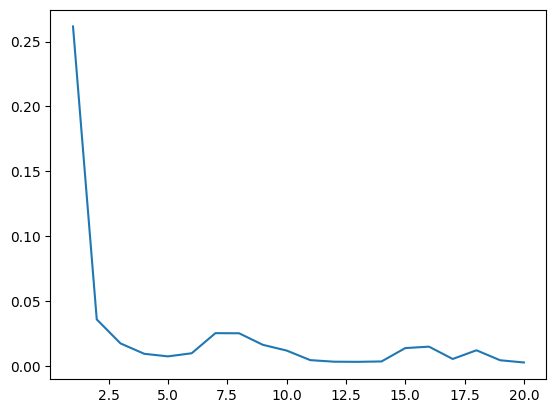

In [28]:
from matplotlib import pyplot as plt
plt.plot( epoch,loss_array)
plt.show()

Inference

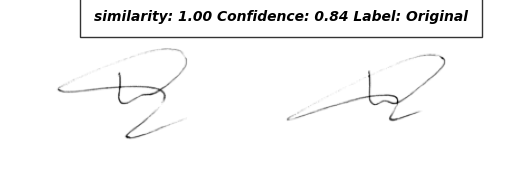

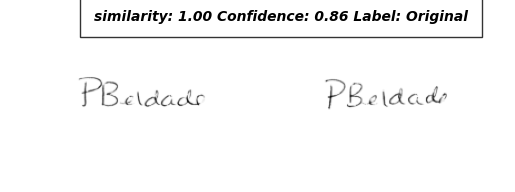

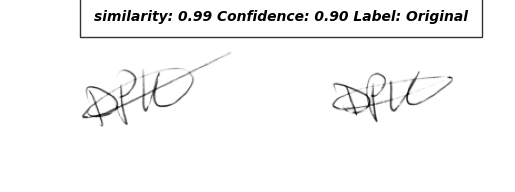

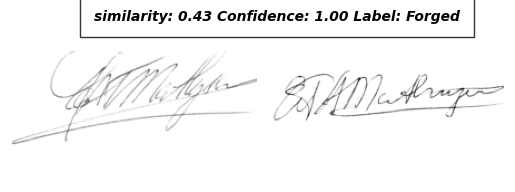

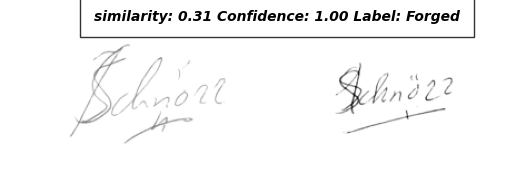

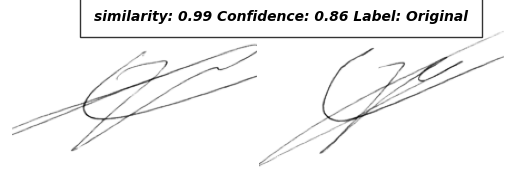

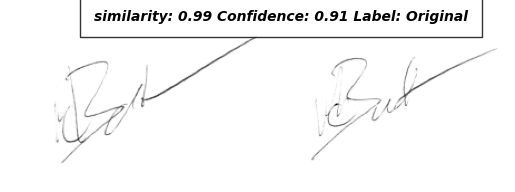

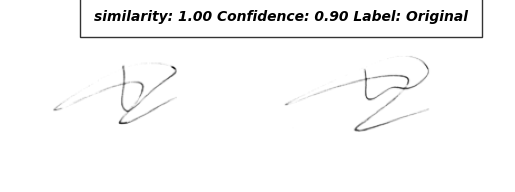

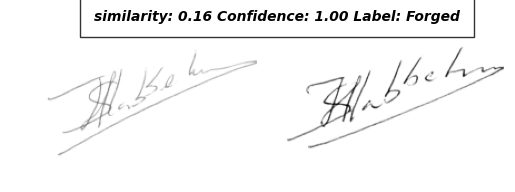

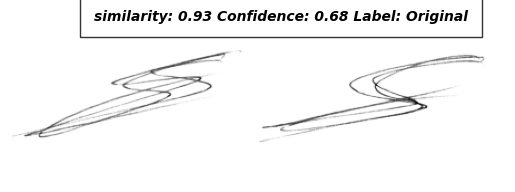

<Figure size 640x480 with 0 Axes>

In [20]:
seed_torch(seed=CFG.seed)

model = SiameseModel()


model.load_state_dict(torch.load('models/convnet_best_loss2.pt', map_location=torch.device('cpu'))['model'])





test_dataset = SignatureDataset(test, CFG.canvas_size, dim=(256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1,
                              shuffle=True,
                              )

counter = 0
label_dict = {1.0:'Forged', 0.0:'Original'}
#CFG.projection2d=True
model.eval()

counter =0
for data in test_loader:
    img1, img2, label = data
    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    if label == 0.0:
        confidence = 1 - confidence
    cos_sim = F.cosine_similarity(op1, op2)

    imshow(torchvision.utils.make_grid(concatenated.unsqueeze(1)), f'similarity: {cos_sim.item():.2f} Confidence: {confidence.item():.2f} Label: {label_dict[label.item()]}')
    plt.savefig('siamese.png')
    counter+=1
    if counter==10:
        break

model metrics

In [39]:
test_dataset = SignatureDataset(test,canvas_size, dim=(256, 256))
test_loader = DataLoader(test_dataset,
                              batch_size=1,
                              shuffle=True,
                               pin_memory=True, drop_last=True)
counter = 0
label_dict = {1.0:'Forged', 0.0:'Original'}
#CFG.projection2d=True
model.eval()

pos_list = np.array([])
neg_list = np.array([])
for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    cos_sim = F.cosine_similarity(op1, op2)
    prediction = np.where(cos_sim.item()<=0.5, 0, 1)
    if label == 0.0:
        neg_list = np.append(neg_list,prediction)
    else:
        pos_list = np.append(pos_list,prediction)

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score ,f1_score,recall_score

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)*100}%\n")
    print(f"\nf1_score of model: {f1_score(true, pred)*100}%\n")
    print(f"\nrecall_score of model: {recall_score(true, pred)*100}%\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


Accuracy of model: 95.54550200104403%


f1_score of model: 95.58620689655173%


recall_score of model: 100.0%



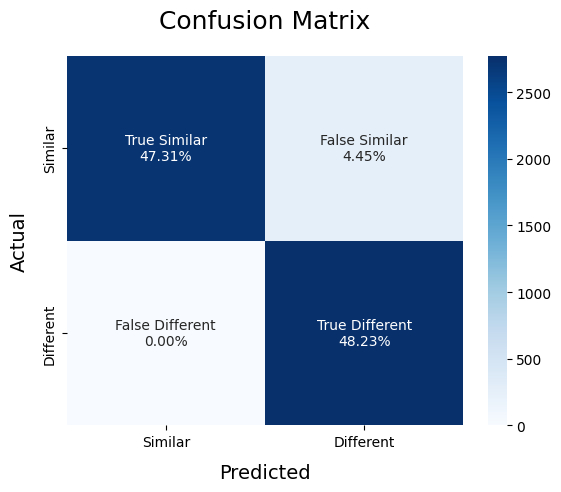

In [41]:
ModelMetrics(pos_list, neg_list)

Testing sample

In [29]:
def __getitem__(real_file_path,test_file_path,canvas_size = (952, 1360),dim=(256, 256)):
      # getting the image path


    img1 = load_signature(real_file_path)
    img2 = load_signature(test_file_path)

    img1 = preprocess_signature(img1, canvas_size,dim)
    img2 = preprocess_signature(img2, canvas_size,dim)
    return torch.tensor(img1), torch.tensor(img2)

In [38]:
def getimage(real_file_path,test_file_path):
    img1 = load_signature(real_file_path)
    img2 = load_signature(test_file_path)
    return torch.tensor(img1), torch.tensor(img2)



In [41]:
def detect_similarity(model_similarity, real_img, img, threshold=0.5):

    label_dict = {1.0:'Forged', 0.0:'Original'}
    model = SiameseModel()
    model.load_state_dict(torch.load(model_similarity, map_location=torch.device('cpu'))['model'])
    model.eval()


    img1,img2 = __getitem__(real_img,img)
    #img1,img2= getimage(real_img,img)

    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')

    cos_sim = F.cosine_similarity(op1, op2)
    prediction = np.where(cos_sim<=threshold, 1, 0)

    if prediction[0] == 0.0:
        confidence = 1 - confidence

    #f, ax = plt.subplots(2,1, figsize=(15,10))
    #ax[0].imshow(img1)
    #ax[1].imshow(img2)
    imshow(torchvision.utils.make_grid(concatenated.unsqueeze(0)), f'similarity: {cos_sim.item():.2f} Confidence: {confidence.item():.2f} Label: {label_dict[prediction[0]]}')
    plt.savefig('siamese.png')




    L = ['Similar','Not-Similar']


    return L[prediction[0]],cos_sim.item(),confidence.item()

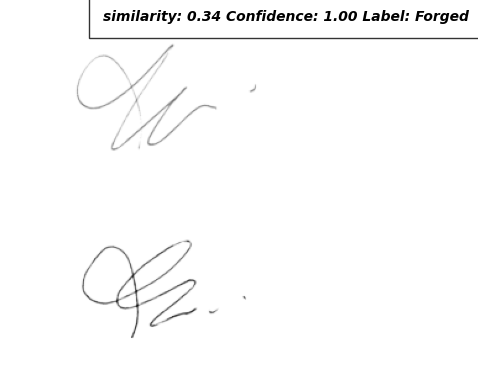

('Not-Similar', 0.3355386257171631, 0.9994008541107178)


<Figure size 640x480 with 0 Axes>

In [42]:
new_image ='/data/sign_data/test/049_forg/01_0114049.PNG'


real_image = 'data/sign_data/test/049/01_049.png'
model_similarity = 'models/convnet_best_loss2.pt'


similarity = detect_similarity(model_similarity, real_image, new_image)
print(similarity)

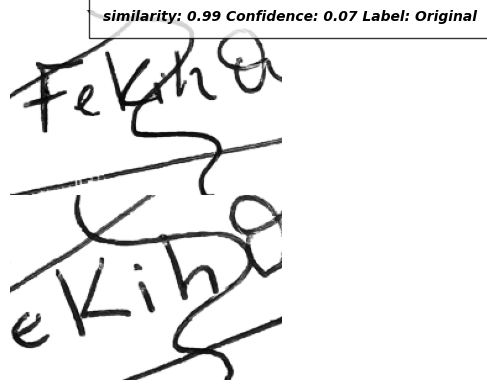

('Similar', 0.9905463457107544, 0.06703078746795654)


<Figure size 640x480 with 0 Axes>

In [43]:
new_image ='ROI_fake.jpg'


real_image = 'ROI_original.jpg'
model_similarity = 'models/convnet_best_loss2.pt'
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)




similarity = detect_similarity(model_similarity, real_image, new_image)
print(similarity)

# Image processing

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


####           load and display an image 

In [2]:
def load_img(img_file):
    image = cv2.imread(img_file)
    return image
    

In [3]:
img=load_img('fake.jpg')

In [6]:
def display(image):
    import matplotlib.image as mpimg
    plt.subplot(2, 2, 4)
    plt.axis('off')  
    #img = mpimg.imread('data/1.jpg')
    imgplot = plt.imshow(image)
    
    plt.show()
    

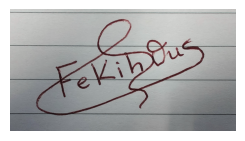

In [7]:
display(img)

In [8]:
image = cv2.imread('fake.jpg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [9]:
#Lower bound of the color range in HSV format.
lower = np.array([90, 38, 0])
#Upper bound of the color range in HSV format.
upper = np.array([145, 255, 255])
#Creates a binary mask where the pixels within the specified HSV range are set to 255 (white),and pixels outside the range are set to 0 (black).
mask = cv2.inRange(hsv, lower, upper)

In [10]:
kernel = np.ones((5,5), np.uint8)


#Performs morphological opening operation on the mask image to remove noise and small blobs.
#This helps to smooth out the mask and fill in gaps in the segmented regions. 
#The iterations=2 parameter specifies the number of times the operation is applied.
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)


#Applies the mask to the original image using bitwise AND operation. This will retain only the pixels in the original image where the corresponding pixel in the mask is non-zero.
result = cv2.bitwise_and(image, image, mask=mask)
result[mask==0] = (255, 255, 255)

### Find contours on extracted mask, combine boxes, and extract ROI

In [11]:
#contour detection on the mask image obtained earlier and extracts the bounding rectangle around the detected contours.


#Finds contours in the mask image
#findContours function returns contours in a tuple. 
cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = np.concatenate(cnts)
x,y,w,h = cv2.boundingRect(cnts)
cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 10)
ROI = result[y:y+h, x:x+w]


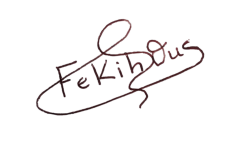

In [12]:
display(result)

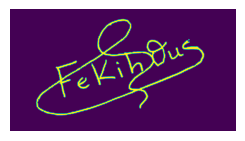

In [13]:
display(mask)

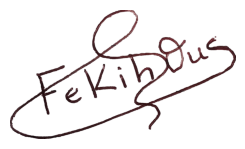

In [14]:
display(ROI)

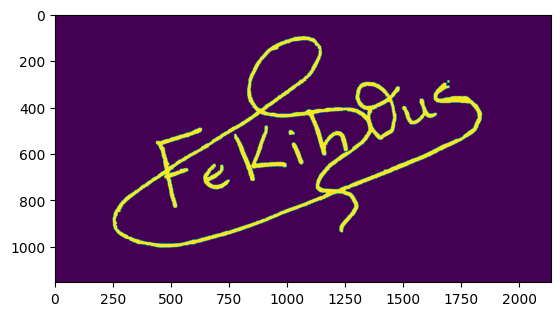

In [15]:
plt.imshow(mask)
plt.show()

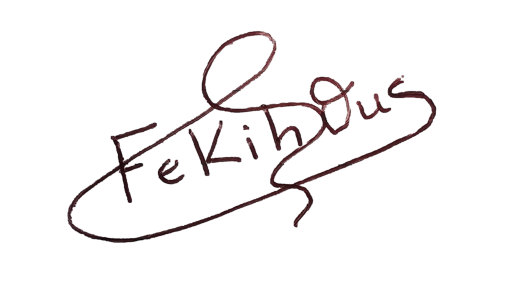

In [16]:
plt.imshow(result)
plt.axis('off')
plt.show()

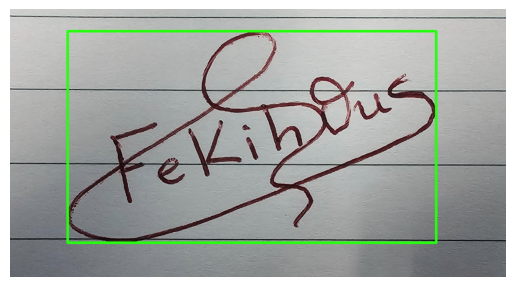

In [17]:
plt.imshow(image)
plt.axis('off')

plt.show()

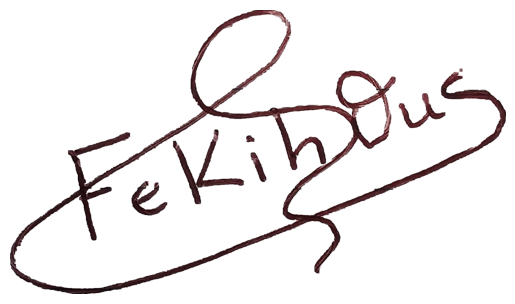

In [18]:
plt.imshow(ROI)
plt.axis('off')
plt.show()

(-0.5, 1586.5, 909.5, -0.5)

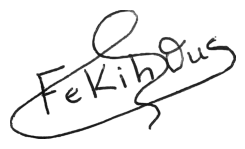

In [19]:
# Convert images to grayscale
ROI_gray = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)

plt.subplot(2, 2, 4)
plt.imshow(ROI_gray, cmap='gray')

plt.axis('off')

In [20]:
def save_img(image_file,image):
    
    cv2.imwrite(image_file, image)